<a href="https://colab.research.google.com/github/kalvin-osoro/ML/blob/main/Pca_crossVal_modelSelect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import linear_model,metrics
from sklearn.linear_model import Lasso,LassoCV
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV,RandomizedSearchCV

# Import dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path='/content/drive/MyDrive/modified_data.csv'
data=pd.read_csv(path)

In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


# Prepare dataset

Search for missing values

In [6]:
data.drop('Id',axis=1,inplace=True)

In [7]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [8]:
data.shape

(1460, 76)

In [9]:
data.isna().any()

MSSubClass       False
MSZoning         False
LotFrontage       True
LotArea          False
Street           False
                 ...  
MoSold           False
YrSold           False
SaleType         False
SaleCondition    False
SalePrice        False
Length: 76, dtype: bool

In [11]:
original_features=list(data.columns)
original_features
len(original_features)

76

In [12]:
features_with_missing=list(data.columns[data.isna().any()])
features_with_missing
len(features_with_missing)

15

In [13]:
len(data)

1460

In [14]:
for feature in features_with_missing:
  print(feature,' ',(data[feature].isna().sum())/len(data)*100)

LotFrontage   17.73972602739726
MasVnrType   0.547945205479452
MasVnrArea   0.547945205479452
BsmtQual   2.5342465753424657
BsmtCond   2.5342465753424657
BsmtExposure   2.6027397260273974
BsmtFinType1   2.5342465753424657
BsmtFinType2   2.6027397260273974
Electrical   0.0684931506849315
FireplaceQu   47.26027397260274
GarageType   5.5479452054794525
GarageYrBlt   5.5479452054794525
GarageFinish   5.5479452054794525
GarageQual   5.5479452054794525
GarageCond   5.5479452054794525


In [17]:
data.dropna(axis=1,thresh=0.5*(len(data)),inplace=True)

In [18]:
mean_fill=['LotFrontage','MasVnrArea']
bfill=['FireplaceQu']
ffill=list(set(features_with_missing)-set(mean_fill)-set(bfill))

In [19]:
ffill

['BsmtFinType1',
 'Electrical',
 'GarageQual',
 'MasVnrType',
 'GarageYrBlt',
 'BsmtCond',
 'BsmtExposure',
 'GarageCond',
 'BsmtQual',
 'BsmtFinType2',
 'GarageFinish',
 'GarageType']

In [20]:
for feature in mean_fill:
  data[feature].fillna(data[feature].mean(),inplace=True)

In [21]:
for feature in ffill:
  data[feature].fillna(method='ffill',inplace=True)

In [22]:
for feature in bfill:
  data[feature].fillna(method='bfill',inplace=True)

In [23]:
data.isna().any()

MSSubClass       False
MSZoning         False
LotFrontage      False
LotArea          False
Street           False
                 ...  
MoSold           False
YrSold           False
SaleType         False
SaleCondition    False
SalePrice        False
Length: 76, dtype: bool

# Encode the dataset

In [24]:
data.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 76, dtype: object

In [26]:
cat_data=data.select_dtypes(include=['object']).copy()
cat_data.head(2)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


In [27]:
cat_features=list(cat_data.columns)
cat_features

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [30]:
nominal=['MSZoning','LandContour','LotConfig','Neighborhood']
ordinal=list(set(cat_features)-set(nominal))
numerical=list(set(original_features)-set(cat_features))
target=['SalePrice']

In [31]:
data[target]

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000
...,...
1455,175000
1456,210000
1457,266500
1458,142125


In [32]:
for feature in ordinal:
  data[feature]=(data[feature].astype('category')).cat.codes

In [33]:
df_nominal=pd.get_dummies(data[nominal])

In [34]:
df_ordinal=data[ordinal]

In [35]:
df_numerical=data[numerical]

In [36]:
encoded_data=pd.concat([df_numerical,df_nominal,df_ordinal],axis=1)

In [37]:
encoded_data.head(3)

,HalfBath,Fireplaces,GarageYrBlt,BsmtFinSF2,TotRmsAbvGrd,MiscVal,EnclosedPorch,BsmtHalfBath,ScreenPorch,BedroomAbvGr,...,SaleType,LotShape,Exterior1st,BsmtFinType1,MasVnrType,SaleCondition,Street,BsmtFinType2,RoofStyle,KitchenQual
0,1,0,2003.0,0,8,0,0,0,0,3,...,8,3,12,2,1,4,1,5,1,2
1,0,1,1976.0,0,6,0,0,1,0,3,...,8,3,8,0,2,4,1,5,1,3
2,1,1,2001.0,0,6,0,0,0,0,3,...,8,0,12,2,1,4,1,5,1,2


In [38]:
encoded_data.shape

(1460, 111)

# Data normalization

In [39]:
encoded_data[target]

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000
...,...
1455,175000
1456,210000
1457,266500
1458,142125


In [40]:
X=encoded_data.drop('SalePrice',axis=1)

In [41]:
y=data[target]
y

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000
...,...
1455,175000
1456,210000
1457,266500
1458,142125


In [42]:
X=X.to_numpy()
X

array([[1.000e+00, 0.000e+00, 2.003e+03, ..., 5.000e+00, 1.000e+00,
        2.000e+00],
       [0.000e+00, 1.000e+00, 1.976e+03, ..., 5.000e+00, 1.000e+00,
        3.000e+00],
       [1.000e+00, 1.000e+00, 2.001e+03, ..., 5.000e+00, 1.000e+00,
        2.000e+00],
       ...,
       [0.000e+00, 2.000e+00, 1.941e+03, ..., 5.000e+00, 1.000e+00,
        2.000e+00],
       [0.000e+00, 0.000e+00, 1.950e+03, ..., 4.000e+00, 3.000e+00,
        2.000e+00],
       [1.000e+00, 0.000e+00, 1.965e+03, ..., 3.000e+00, 1.000e+00,
        3.000e+00]])

In [43]:
y=y.to_numpy()
y

array([[208500],
       [181500],
       [223500],
       ...,
       [266500],
       [142125],
       [147500]])

In [44]:
X.shape

(1460, 110)

In [45]:
y.shape

(1460, 1)

In [46]:
X=StandardScaler().fit_transform(X)
y=StandardScaler().fit_transform(y)

In [47]:
y

array([[ 0.34727322],
       [ 0.00728832],
       [ 0.53615372],
       ...,
       [ 1.07761115],
       [-0.48852299],
       [-0.42084081]])

# PCA dimensionality reduction

In [49]:
pca=PCA(n_components=2)
p_components=pca.fit_transform(X)

In [50]:
p_components

array([[ 2.40853413, -1.33032774],
       [ 0.43195621,  2.6230287 ],
       [ 2.82844267, -0.85528513],
       ...,
       [ 1.25987706, -0.86521417],
       [-2.83066257,  3.18097712],
       [-0.7566452 ,  2.6812601 ]])

In [51]:
pca.explained_variance_ratio_

array([0.10207313, 0.04345606])

# Visualize data

In [53]:

pca_data = pd.DataFrame(p_components,columns=['PC1','PC2'])
target_data = pd.DataFrame(y,columns=['SalePrice'])
final_data = pd.concat([pca_data,target_data],axis=1)
final_data

,PC1,PC2,SalePrice
0,2.408534,-1.330328,0.347273
1,0.431956,2.623029,0.007288
2,2.828443,-0.855285,0.536154
3,-1.364219,0.552527,-0.515281
4,5.311982,-0.222456,0.869843
...,...,...,...
1455,1.306602,-2.290549,-0.074560
1456,1.095838,3.176948,0.366161
1457,1.259877,-0.865214,1.077611
1458,-2.830663,3.180977,-0.488523


In [54]:
X=p_components

In [55]:
X

array([[ 2.40853413, -1.33032774],
       [ 0.43195621,  2.6230287 ],
       [ 2.82844267, -0.85528513],
       ...,
       [ 1.25987706, -0.86521417],
       [-2.83066257,  3.18097712],
       [-0.7566452 ,  2.6812601 ]])

In [56]:
y

array([[ 0.34727322],
       [ 0.00728832],
       [ 0.53615372],
       ...,
       [ 1.07761115],
       [-0.48852299],
       [-0.42084081]])

# Training a sngle model

In [57]:
regressor=LassoCV()

In [ ]:
regressor.fit(X,y)

In [60]:
regressor.coef_

array([0.25351581, 0.01759368])

In [61]:
regressor.intercept_

4.318517278741347e-17

# Example plot

In [63]:
final_data_array=final_data.to_numpy()

In [65]:
min_val=np.min(final_data_array, axis=0)
max_val=np.max(final_data_array, axis=0)
X_plot,Y_plot=np.meshgrid(np.linspace(min_val[0],max_val[0],20),np.linspace(min_val[1],max_val[1],20))


In [66]:
w_1 = regressor.coef_[0]
w_2 = regressor.coef_[1]
b = regressor.intercept_
Z_plot = w_1*X_plot + w_2*Y_plot + b

In [69]:
w_2

0.01759368123485081

Text(0.5, 0.92, 'Plane of best fit')

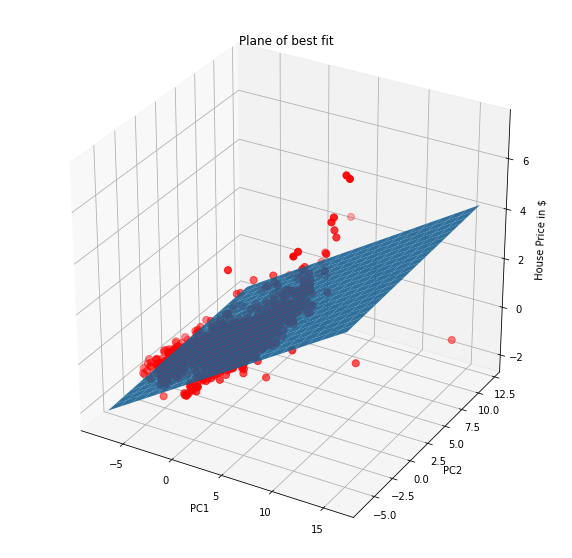

In [70]:
fig1=plt.figure(figsize=(10,10))
ax=fig1.gca(projection='3d')
ax.plot_surface(X_plot,Y_plot,Z_plot, rstride=1,cstride=1,alpha=0.9)
ax.scatter(final_data_array[:,0],final_data_array[:,1],final_data_array[:,2], c='r',s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
ax.set_zlabel('House Price in $')
ax.set_title('Plane of best fit')


# Data splitting

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)

In [72]:
y_train

array([[ 1.52462833],
       [-0.69786554],
       [ 0.65791868],
       ...,
       [-0.3767687 ],
       [ 0.99576293],
       [-0.60972131]])

# Model selection, train different models

In [87]:
result = {}
models = {'LinearRegression':linear_model.LinearRegression(),
          'Lasso':linear_model.Lasso(),
          'Ridge':linear_model.Ridge(),
          'ElasticNet':linear_model.ElasticNet()}

for i in models:
  models[i].fit(X_train,y_train)
  accuracy = models[i].score(X_test,y_test)
  result[i]=[accuracy]
pd.DataFrame(result)

,LinearRegression,Lasso,Ridge,ElasticNet
0,0.668143,0.611131,0.668153,0.655638


# K-fold cross validation

In [86]:
kfold = KFold(n_splits=4)
for i in models:
  regressor = models[i]
  c_validated = cross_val_score(regressor,X_train,y_train,cv=kfold)  
  accuracy = c_validated.mean()
  result[i]=[accuracy]
pd.DataFrame(result)

,LinearRegression,Lasso,Ridge,ElasticNet
0,0.74614,0.658431,0.746142,0.715071


# Hyperparameter tuning

grid search

In [88]:
for i in models:
  regressor = models[i]
  if i == 'Lasso':
    lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03],'max_iter':[1000,1100,2000],'tol':[0.001,0.0001,0.000001]}
    grid = GridSearchCV(regressor,param_grid=lasso_params,cv=2,n_jobs=-1)
    results = grid.fit(X_train,y_train)
    print("Best Params are ", results.best_params_)
    #accuracy = results.score(X_test,y_test)
    accuracy=results.best_score_
  else:    
    c_validated = cross_val_score(regressor,X_train,y_train,cv=kfold)  
    accuracy = c_validated.mean()
  result[i]=[accuracy]
pd.DataFrame(result)

Best Params are  {'alpha': 0.02, 'max_iter': 1000, 'tol': 0.0001}


,LinearRegression,Lasso,Ridge,ElasticNet
0,0.74614,0.746366,0.746142,0.715071


Random search

In [89]:
for i in models:
  regressor = models[i]
  if i == 'Lasso':
    random = RandomizedSearchCV(regressor,param_distributions=lasso_params,cv=3,n_jobs=-1)
    results = random.fit(X_train,y_train)
    print(results.best_score_)
    print("Best Params are ", results.best_params_)
    #accuracy = results.score(X_test,y_test)
    accuracy=results.best_score_
  else:    
    c_validated = cross_val_score(regressor,X_train,y_train,cv=kfold)  
    accuracy = c_validated.mean()
  result[i]=[accuracy]
pd.DataFrame(result)

0.7441148794127953
Best Params are  {'tol': 1e-06, 'max_iter': 1100, 'alpha': 0.02}


,LinearRegression,Lasso,Ridge,ElasticNet
0,0.74614,0.744115,0.746142,0.715071
